<a href="https://colab.research.google.com/github/awenroberts/QM2-Project/blob/main/Kento_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import pandas as pd

df_asylum = pd.read_csv('Asylum Seeker accommodation.csv', encoding='latin1')
df_protest = pd.read_csv('lad_code.csv', encoding='latin1') # The file your group member made

# Convert People column to numeric, coercing errors to NaN
df_asylum['People'] = pd.to_numeric(df_asylum['People'], errors='coerce')

# Define Visible types
visible_types = [
    'Contingency Accommodation - Hotel',
    'Contingency Accommodation - Other',
    'Other Accommodation'
]

# Calculate total visible people per LA per Quarter
la_visible = df_asylum[df_asylum['Accommodation Type'].isin(visible_types)].groupby(
    ['LAD Code', 'Year-Quarter']
)['People'].sum().reset_index()

# Sort
la_visible = la_visible.sort_values(['LAD Code', 'Year-Quarter'])

In [58]:
display(la_visible.head())

,LAD Code,Year-Quarter,People
0,E06000004,2024 Q4,27.0
1,E06000004,2025 Q1,19.0
2,E06000004,2025 Q2,18.0
3,E06000004,2025 Q3,31.0
4,E06000006,2024 Q4,311.0


In [59]:
la_visible['People'] = pd.to_numeric(la_visible['People'], errors='coerce')

# Use .diff() within each group
la_visible['shock_change'] = la_visible.groupby('LAD Code')['People'].diff()

# Fill NaN values with 0
la_visible['shock_change'] = la_visible['shock_change'].fillna(0)

In [60]:
display(la_visible.head())

,LAD Code,Year-Quarter,People,shock_change
0,E06000004,2024 Q4,27.0,0.0
1,E06000004,2025 Q1,19.0,-8.0
2,E06000004,2025 Q2,18.0,-1.0
3,E06000004,2025 Q3,31.0,13.0
4,E06000006,2024 Q4,311.0,0.0


In [61]:
# Aggregate the protests by LAD and Quarter

# Convert Date column to datetime objects
df_protest['Date'] = pd.to_datetime(df_protest['Date'], format='%d/%m/%Y')

# Create an Year-Quarter column in df_protest to match df_asylum format
df_protest['Year-Quarter'] = df_protest['Date'].dt.year.astype(str) + ' Q' + df_protest['Date'].dt.quarter.astype(str)

protest_counts = df_protest.groupby(['lad_code', 'Year-Quarter']).size().reset_index(name='protest_count')

# Merge the datasets
final_analysis = pd.merge(
    la_visible,
    protest_counts,
    left_on=['LAD Code', 'Year-Quarter'],
    right_on=['lad_code', 'Year-Quarter'],
    how='left'
)

# Replace NaNs in protest_count with 0
final_analysis['protest_count'] = final_analysis['protest_count'].fillna(0)

# Final Correlation Calculation
correlation = final_analysis['shock_change'].corr(final_analysis['protest_count'])
print(f"The Pearson correlation coefficient is: {correlation:.3f}")

The Pearson correlation coefficient is: -0.042


In [62]:
display(protest_counts.head())

,lad_code,Year-Quarter,protest_count
0,E06000009,2025 Q3,1
1,E06000021,2025 Q3,1
2,E06000023,2025 Q2,1
3,E06000023,2025 Q3,3
4,E06000023,2025 Q4,1


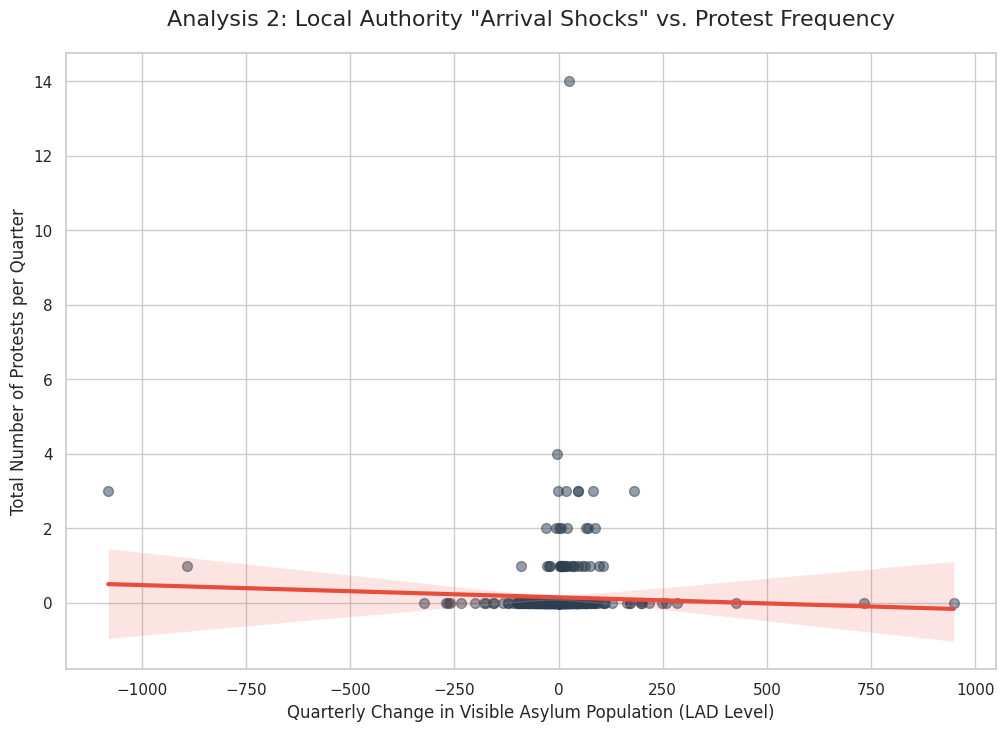

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the visual style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))

# Create the Regression Plot
plot = sns.regplot(
    data=final_analysis,
    x='shock_change',
    y='protest_count',
    scatter_kws={'alpha':0.5, 's':50, 'color':'#2c3e50'}, # Style the dots
    line_kws={'color':'#e74c3c', 'lw':3}                # Style the line
)

# Add Titles and Labels
plt.title('Analysis 2: Local Authority "Arrival Shocks" vs. Protest Frequency', fontsize=16, pad=20)
plt.xlabel('Quarterly Change in Visible Asylum Population (LAD Level)', fontsize=12)
plt.ylabel('Total Number of Protests per Quarter', fontsize=12)

# Highlight specific outliers (like high-growth/high-protest areas)
plt.show()